#imports

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# - - - -- - - - - - - - - -- - - - - - - -[INFO]- - - -- - - - - - - - - -- - - - - - - -
Для сравнения в data_for_KMeans были выкинуты заявки (их стало 860, а не 880 как в исходном шаблоне у Софии), в которых у материала за всю историю не было ни одного поставщика

# Первая модель KMeans:
❗ Кластеризует только по расположению грузополучателей
> Количество кластеров(8) подбирал методом локтя (см. график, будет ниже)

In [48]:
df = pd.read_csv("data_for_KMeans.csv")
# df.info()
# df.head().T

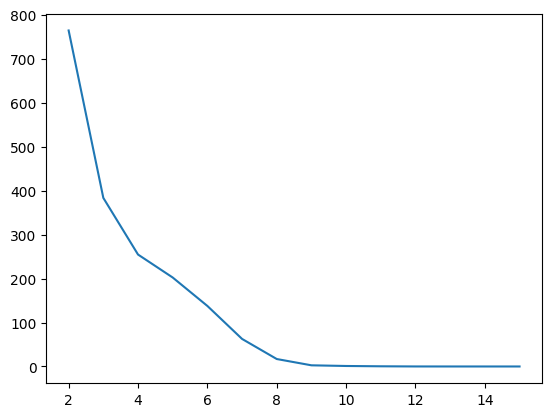

In [49]:
to_fit1 = df[["reciever_lat", "reciever_long"]]

score = []
for i in range(2, 16):
    pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clust', KMeans(i, random_state=42, n_init="auto")),
            ]).fit(to_fit1)

    label_pred = pipe.predict(to_fit1)
    score.append(pipe[1].inertia_)
    df["id_lot"] = label_pred
plt.plot(np.arange(2,16), score)

In [50]:
to_fit1 = df[["reciever_lat", "reciever_long"]]
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clust', KMeans(8, random_state=42, n_init="auto")),
        ]).fit(to_fit1)

label_pred = pipe.predict(to_fit1)
df["id_lot"] = label_pred
ans = pd.DataFrame(df.groupby("ID Лота")["id_lot"].mean())
ans["id_lot"].value_counts()
# тут смотрю, что почти все старые позиции, которые были распределены человеком в одинаковые лоты,
# распределены моделью также в одинаковые лоты (есть только 3 "ID Лота", для которых это неверно)

,count
id_lot,
4.000000,28
1.000000,14
7.000000,13
3.000000,10
0.000000,8
2.000000,6
5.000000,5
6.000000,2
4.500000,1


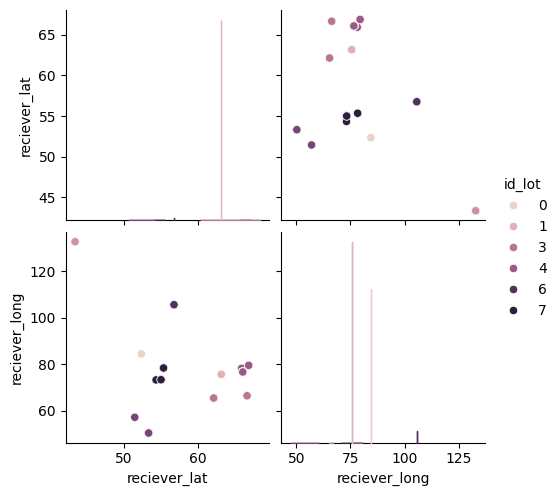

In [51]:
sns.pairplot(df[["reciever_lat", "reciever_long","id_lot"]], hue='id_lot')

In [52]:
df.rename(columns={"Поставщик": "Наиболее вероятный поставщик"}, inplace=True)
df.head().T
#раскоментить, чтобы сохранить
# df.to_csv("KMeans_result_for_1month_only_recievers.csv", index=False)

# Вторая модель KMeans:
❗ Кластеризует по:

1) расположению грузополучателей

2) расстоянию между грузополучателем и ближайшим поставщиком (тут лучше подобрать коэф, чтобы это расстояние влияло меньше, я пока взял просто 0.5)
> Количество кластеров(8) подбирал методом локтя (см. график, будет ниже)

In [53]:
df = pd.read_csv("data_for_KMeans.csv")
# df.info()
# df.head().T

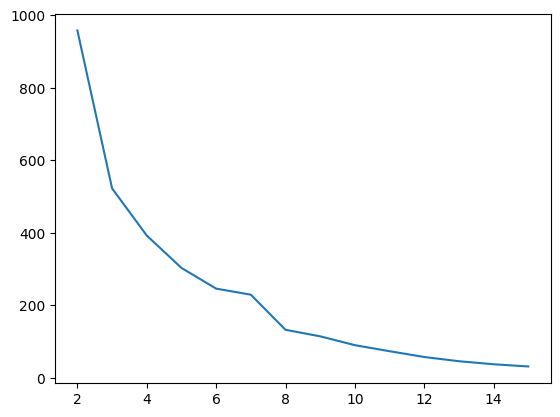

In [54]:
score = []
for i in range(2, 16):
    to_fit1 = df[["reciever_lat", "reciever_long", "distance"]]
    to_fit1 = pd.DataFrame(StandardScaler().fit_transform(to_fit1), columns=["reciever_lat", "reciever_long", "distance"])
    to_fit1["distance"] *= 0.5

    pipe = Pipeline([
        ('clust', KMeans(i, random_state=42, n_init="auto"))
        ]).fit(to_fit1)

    label_pred = pipe.predict(to_fit1)
    score.append(pipe[0].inertia_)
    df["id_lot"] = label_pred

plt.plot(np.arange(2,16), score)

In [55]:
to_fit1 = df[["reciever_lat", "reciever_long", "distance"]]
to_fit1 = pd.DataFrame(StandardScaler().fit_transform(to_fit1), columns=["reciever_lat", "reciever_long", "distance"])
to_fit1["distance"] *= 0.5
pipe = Pipeline([
        ('clust', KMeans(8, random_state=42, n_init="auto"))
        ]).fit(to_fit1)

label_pred = pipe.predict(to_fit1)
df["id_lot"] = label_pred
ans = pd.DataFrame(df.groupby("ID Лота")["id_lot"].mean())
# ans["id_lot"].value_counts()

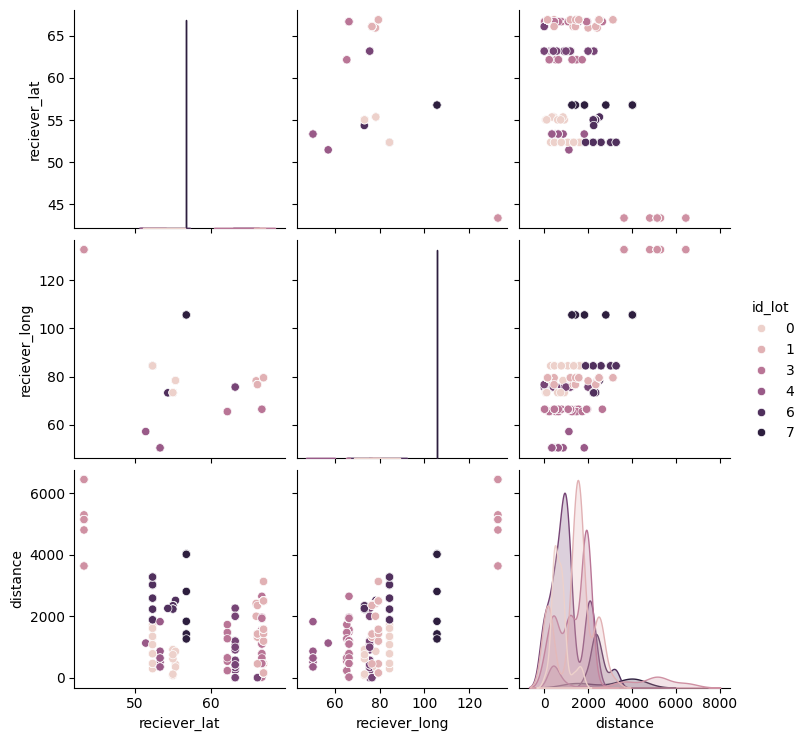

In [56]:
sns.pairplot(df[["reciever_lat", "reciever_long", "distance", "id_lot"]], hue='id_lot')

In [57]:
df.rename(columns={"Поставщик": "Наиболее вероятный поставщик"}, inplace=True)
df.head().T
#раскоментить, чтобы сохранить
# df.to_csv("KMeans_result_for_1month_recievers_and_dist.csv", index=False)

# check

In [60]:
res = pd.read_csv("KMeans_result_for_1month_only_recievers.csv")
df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Клиент,39295.0,64025.0,64025.0,57650.0,57650.0
Материал,770000818063,770000594878,770000831667,770000869461,770000869463
Краткий текст материала,Кабель FYO2RMU 2х4х4хSML 90756м Nestor,"Кабель ИнСил-ОЭвзнг(А)-ХЛ 4х2х1,0-660","Кабель К9РВСБПМнг(А)-HF 4х1,5ок(N)-1","Провод ПуВнг(А)-LS 1х1,0 (PE)","Провод ПуГВнг(А)-LS 1х6,0 (PE)"
ЕИ,ШТ,КМ,КМ,КМ,КМ
Общее количество,2.0,0.695,0.32,0.03,0.03
Месяц поставки,12,8,10,8,8
Год поставки,2019,2020,2020,2020,2020
Полугодие,2,2,2,2,2
Срок поставки,2019-12-31,2020-08-30,2020-10-10,2020-08-30,2020-08-30
